### scQuint Differential Splicing

In [4]:
##Differential intron splicing analysis using scQuint. Scripts by Gonzalo Benegas and Derek Bogdanoff

In [1]:
!date

Mon Jan 23 00:10:25 PST 2023


In [2]:
!echo $CONDA_PREFIX

/c4/home/derek/miniconda3/envs/squint_2


In [3]:
#analysis approach from:
#https://github.com/songlab-cal/scquint/blob/main/differential_splicing_example.ipynb

In [4]:
import anndata

import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from scquint.differential_splicing import run_differential_splicing
from scquint.data import calculate_PSI

/c4/home/derek/miniconda3/envs/squint_2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from scquint.data import calculate_PSI
from scquint.differential_splicing import run_differential_splicing, run_differential_splicing_for_each_group, find_marker_introns, mask_PSI
from scquint.dimensionality_reduction.pca import run_pca

In [46]:
import os
output_dir = '/c4/home/derek/data1/derek/scSLR/notebooks/fig2/plots/'
os.makedirs(output_dir, exist_ok=True)

In [8]:
input_dir = output_dir= '/c4/home/derek/data1/derek/data_scSLR/PBMC/'

In [9]:
adata_spl = sc.read_h5ad(input_dir+'spl_3prime_splice_acceptor.h5ad')

In [10]:
adata_exp = sc.read_h5ad(input_dir+'gene_expression.h5ad')

In [11]:
groupby = "ct2"
adata_exp.obs[groupby].value_counts()

cM               6218
T4_Naive         2526
T8_Mem           2162
T4_Mem           2139
B_Naive          1436
ncM              1162
NK_CD16+         1025
T8_Naive          752
NKT               505
T4_Treg           352
Tgd_1             280
Tgd_2             247
cDC_2             245
B_Mem_Prolif      203
B_Mem             202
T4_Mem_Prolif     168
B_Preplasma       166
T_NK_Prolif       154
T8_Mem_Prolif     140
PB                135
T8_MAIT           132
NK_Prolif          62
NK_CD56++          62
PB_Prolif          51
Progen_MEP         48
pDC                45
Progen_CMP         40
cDC_1              13
Progen_MPP          2
Progen_CLP          1
Name: ct2, dtype: int64

In [19]:
old_to_new = {
    'T8_Mem':'T_Mem',
    'T4_Mem':'T_Mem',
    'T8_Naive':'T_Naive',
    'T4_Naive':'T_Naive',
}
adata_spl.obs['ct0'] = (
    adata_spl.obs['ct2']
    .map(old_to_new)
    .astype('category')
)

barcode_index
AAACCTGAGACAAGCC-1-22    T_Naive
AAACCTGAGATATGCA-1-22        NaN
AAACCTGAGCTGATAA-1-22        NaN
AAACCTGAGGTCGGAT-1-22      T_Mem
AAACCTGAGTACGTTC-1-22      T_Mem
                          ...   
TTTGTCAGTGTTGAGG-1-23    T_Naive
TTTGTCAGTTGGACCC-1-23        NaN
TTTGTCAGTTGTACAC-1-23      T_Mem
TTTGTCATCCGGGTGT-1-23        NaN
TTTGTCATCTACTATC-1-23        NaN
Name: ct0, Length: 20673, dtype: category
Categories (2, object): ['T_Mem', 'T_Naive']

In [22]:
adata_spl.obs['ct0'] = (
    adata_spl.obs["ct2"]
    .map(lambda x: {
    'T8_Mem':'T_Mem',
    'T4_Mem':'T_Mem',
    'T8_Naive':'T_Naive',
    'T4_Naive':'T_Naive',
}.get(x, x))
    .astype("category")
)

In [23]:
adata_spl.obs['ct0']

barcode_index
AAACCTGAGACAAGCC-1-22    T_Naive
AAACCTGAGATATGCA-1-22         cM
AAACCTGAGCTGATAA-1-22         cM
AAACCTGAGGTCGGAT-1-22      T_Mem
AAACCTGAGTACGTTC-1-22      T_Mem
                          ...   
TTTGTCAGTGTTGAGG-1-23    T_Naive
TTTGTCAGTTGGACCC-1-23        ncM
TTTGTCAGTTGTACAC-1-23      T_Mem
TTTGTCATCCGGGTGT-1-23      Tgd_1
TTTGTCATCTACTATC-1-23         cM
Name: ct0, Length: 20673, dtype: category
Categories (28, object): ['B_Mem', 'B_Mem_Prolif', 'B_Naive', 'B_Preplasma', ..., 'cDC_2', 'cM', 'ncM', 'pDC']

/c4/home/derek/miniconda3/envs/squint_2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/c4/home/derek/miniconda3/envs/squint_2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/c4/home/derek/miniconda3/envs/squint_2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


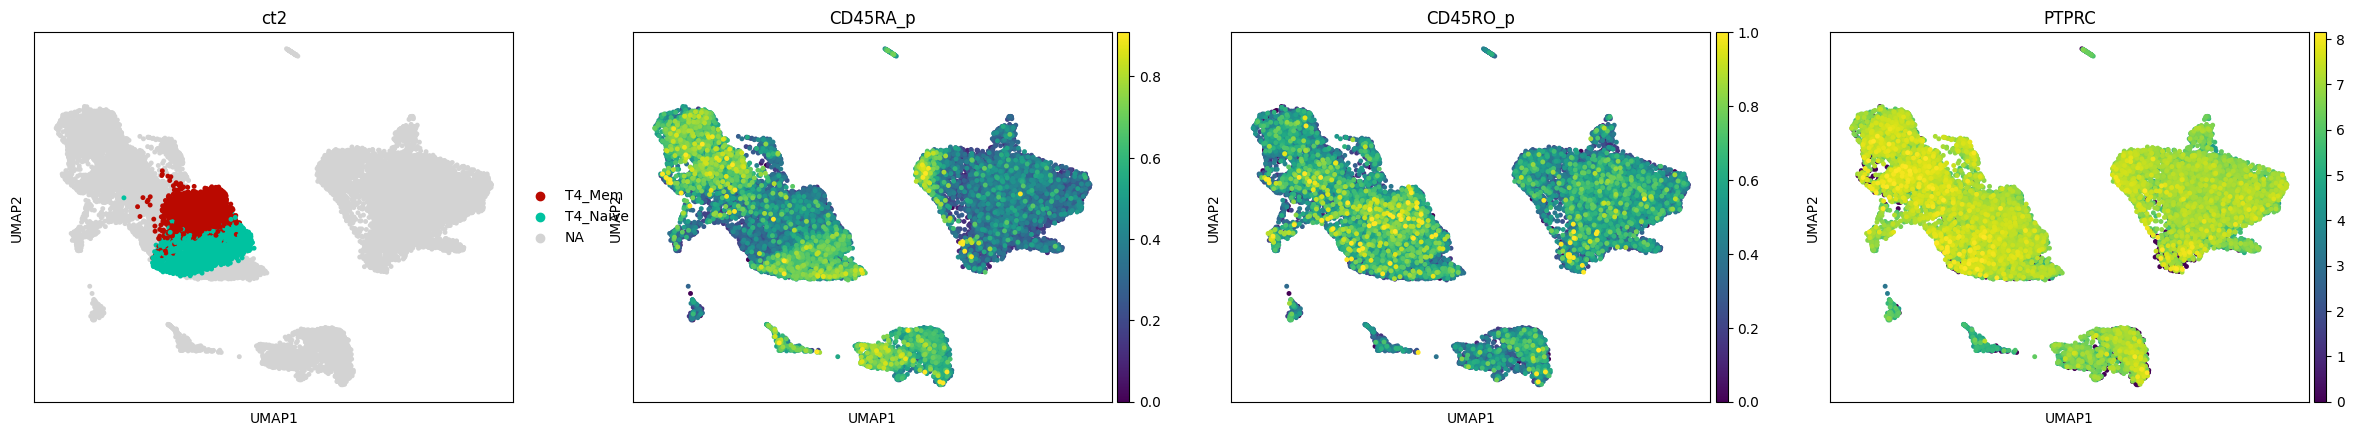

In [13]:
sc.pl.umap(adata_exp,
           color=['ct2','CD45RA_p','CD45RO_p','PTPRC'],
           groups=['T4_Mem','T4_Naive'],
           vmax='p99.9',
           size=50,
           ncols=4,
          )
       

In [14]:
adata_spl.layers["PSI_raw"] = calculate_PSI(adata_spl)

/c4/home/derek/bin/scquint/scquint/data.py:203: RuntimeWarning: invalid value encountered in divide
  return X / intron_group_sums[:,groups]


In [ ]:
#groups_test = adata_spl.obs[groupby].value_counts()[:14].index.values.astype(str).tolist()[:9]

In [24]:
groups_test = ['T_Mem','T_Naive','B_Mem','B_Naive']

In [27]:
groupby = "ct0"

In [28]:
%%time


diff_spl_intron_groups, diff_spl_introns = run_differential_splicing_for_each_group(
    adata_spl, 
    groupby, 
    groups=groups_test,
    subset_to_groups=True,
    min_cells_per_intron_group=50, 
    min_total_cells_per_intron=50, 
    n_jobs=-1,
)

T_Mem
sample sizes:  4301 4916
(9217, 3282)
filter_min_cells_per_feature
filter_singletons
(9217, 1986)
filter_min_global_proportion
filter_singletons
(9217, 1981)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(9217, 1934)
Number of intron groups:  912
Number of introns:  1934


100%|██████████████████████████████████████████████████████████████████| 912/912 [01:52<00:00,  8.13it/s]


T_Naive
sample sizes:  3278 5939
(9217, 3282)
filter_min_cells_per_feature
filter_singletons
(9217, 1986)
filter_min_global_proportion
filter_singletons
(9217, 1981)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(9217, 1827)
Number of intron groups:  859
Number of introns:  1827


100%|█████████████████████████████████████████████████████████████████| 859/859 [00:03<00:00, 232.40it/s]


B_Mem
sample sizes:  202 9015
(9217, 3282)
filter_min_cells_per_feature
filter_singletons
(9217, 1986)
filter_min_global_proportion
filter_singletons
(9217, 1981)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(9217, 388)
Number of intron groups:  176
Number of introns:  388


100%|█████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 646.55it/s]


B_Naive
sample sizes:  1436 7781
(9217, 3282)
filter_min_cells_per_feature
filter_singletons
(9217, 1986)
filter_min_global_proportion
filter_singletons
(9217, 1981)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(9217, 1128)
Number of intron groups:  519
Number of introns:  1128


100%|█████████████████████████████████████████████████████████████████| 519/519 [00:02<00:00, 240.82it/s]


CPU times: user 16.1 s, sys: 9.92 s, total: 26 s
Wall time: 2min 21s


In [29]:
diff_spl_intron_groups.head()

,p_value,ll_null,ll,n_classes,gene_id,gene_name,max_abs_delta_psi,max_abs_lfc_psi,ranking,p_value_adj,test_group,name
0,6.090348e-97,-2770.1073373822996,-2548.563288592866,3,ENSG00000081237,PTPRC,0.313239,1.779720,0,5.554397e-94,T_Mem,PTPRC_chr1_198703297_+
1,5.732636e-48,-742.4144985855874,-636.5447276889836,2,ENSG00000075884,ARHGAP15,0.450497,1.889696,1,2.614082e-45,T_Mem,ARHGAP15_chr2_143250510_+
2,3.973159e-36,-1157.7665618447559,-1079.0148264485301,2,ENSG00000081237,PTPRC,0.278915,1.223306,2,1.207840e-33,T_Mem,PTPRC_chr1_198699563_+
3,6.978571e-26,-6143.7128360625375,-6088.376388732624,2,ENSG00000138326,RPS24,0.091366,0.354134,3,1.591114e-23,T_Mem,RPS24_chr10_78040614_+
4,1.626889e-20,-2773.076418278235,-2729.976790335537,2,ENSG00000227507,LTB,0.122501,0.513195,4,2.967445e-18,T_Mem,LTB_chr6_31581631_-


In [30]:
sig_diff_spl_intron_groups = diff_spl_intron_groups.query('p_value_adj < 0.05 and max_abs_delta_psi > 0.05')

sig_diff_spl_intron_groups.shape

(111, 12)

In [31]:
sig_diff_spl_intron_groups.gene_name.nunique()

70

In [32]:
diff_spl_introns[diff_spl_introns.intron_group.isin(sig_diff_spl_intron_groups.name)].shape

(467, 22)

In [33]:
diff_spl_intron_groups.to_csv('/c4/home/derek/data1/derek/data_scSLR/PBMC/diff_intron_groups_T4.csv')
    
diff_spl_introns.to_csv('/c4/home/derek/data1/derek/data_scSLR/PBMC/diff_introns_T4.csv')

In [34]:
marker_introns = find_marker_introns(
    sig_diff_spl_intron_groups, diff_spl_introns, 10, min_delta_psi=0.3,
)
marker_introns = {c: marker_introns[c] for c in groups_test} # just reordering
marker_introns

{'T_Mem': ['FOXP1_chr3:71299881-71359149',
  'FYB1_chr5:39202988-39270568',
  'GMPR2_chr14:24232789-24233218'],
 'T_Naive': ['RASSF1_chr3:50332155-50337172'],
 'B_Mem': [],
 'B_Naive': ['PTPRC_chr1:198696910-198699563',
  'ARHGAP15_chr2:143228669-143250510',
  'SET_chr9:128684008-128691169',
  'ARID5B_chr10:62000322-62050887',
  'TANK_chr2:161137064-161179613',
  'POLD4_chr11:67353078-67353302']}

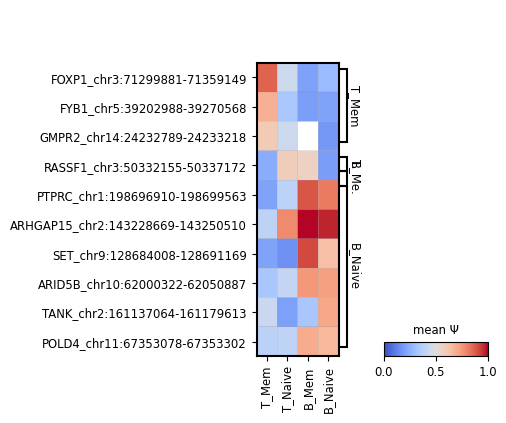

In [35]:
sc.pl.matrixplot(
    mask_PSI(adata_spl[adata_spl.obs[groupby].isin(groups_test)], 
             marker_introns, 
             groupby, min_cells=5),
    marker_introns,
    groupby, 
    cmap='coolwarm',
    categories_order=groups_test,
    swap_axes=True,
    layer="PSI_raw_masked", 
    colorbar_title="mean Ψ",
    vmin=0, vmax=1,
    dendrogram=False,
)


In [36]:
[i for i in adata_spl.var_names if i.startswith('PTPRC')]

['PTPRC_chr1:198692374-198699563',
 'PTPRC_chr1:198692374-198703297',
 'PTPRC_chr1:198696910-198699563',
 'PTPRC_chr1:198699705-198703297',
 'PTPRC_chr1:198702531-198703297']

In [23]:
adata_spl.obs_names

Index(['AAACCTGAGACAAGCC-1-22', 'AAACCTGAGATATGCA-1-22',
       'AAACCTGAGCTGATAA-1-22', 'AAACCTGAGGTCGGAT-1-22',
       'AAACCTGAGTACGTTC-1-22', 'AAACCTGAGTCAAGCG-1-22',
       'AAACCTGAGTCGCCGT-1-22', 'AAACCTGAGTTGCAGG-1-22',
       'AAACCTGAGTTGTAGA-1-22', 'AAACCTGCAACAACCT-1-22',
       ...
       'TTTGTCACAGTTCATG-1-23', 'TTTGTCAGTAGAAGGA-1-23',
       'TTTGTCAGTCTTGTCC-1-23', 'TTTGTCAGTCTTTCAT-1-23',
       'TTTGTCAGTGCAGGTA-1-23', 'TTTGTCAGTGTTGAGG-1-23',
       'TTTGTCAGTTGGACCC-1-23', 'TTTGTCAGTTGTACAC-1-23',
       'TTTGTCATCCGGGTGT-1-23', 'TTTGTCATCTACTATC-1-23'],
      dtype='object', name='barcode_index', length=20673)

In [38]:
adata_spl.obs_names = adata_spl.obs_names.str.replace(pat='-1-22',repl='-0').str.replace(pat='-1-23',repl='-1')

adata_5prime = sc.read_h5ad('/c4/home/derek/data1/derek/data_scSLR/PBMC/5prime_exp_h5ad')

adata_spl = adata_spl[adata_spl.obs_names.isin(adata_5prime.obs_names)]

adata_spl.obsm['X_umap'] = adata_5prime.obsm['X_umap']

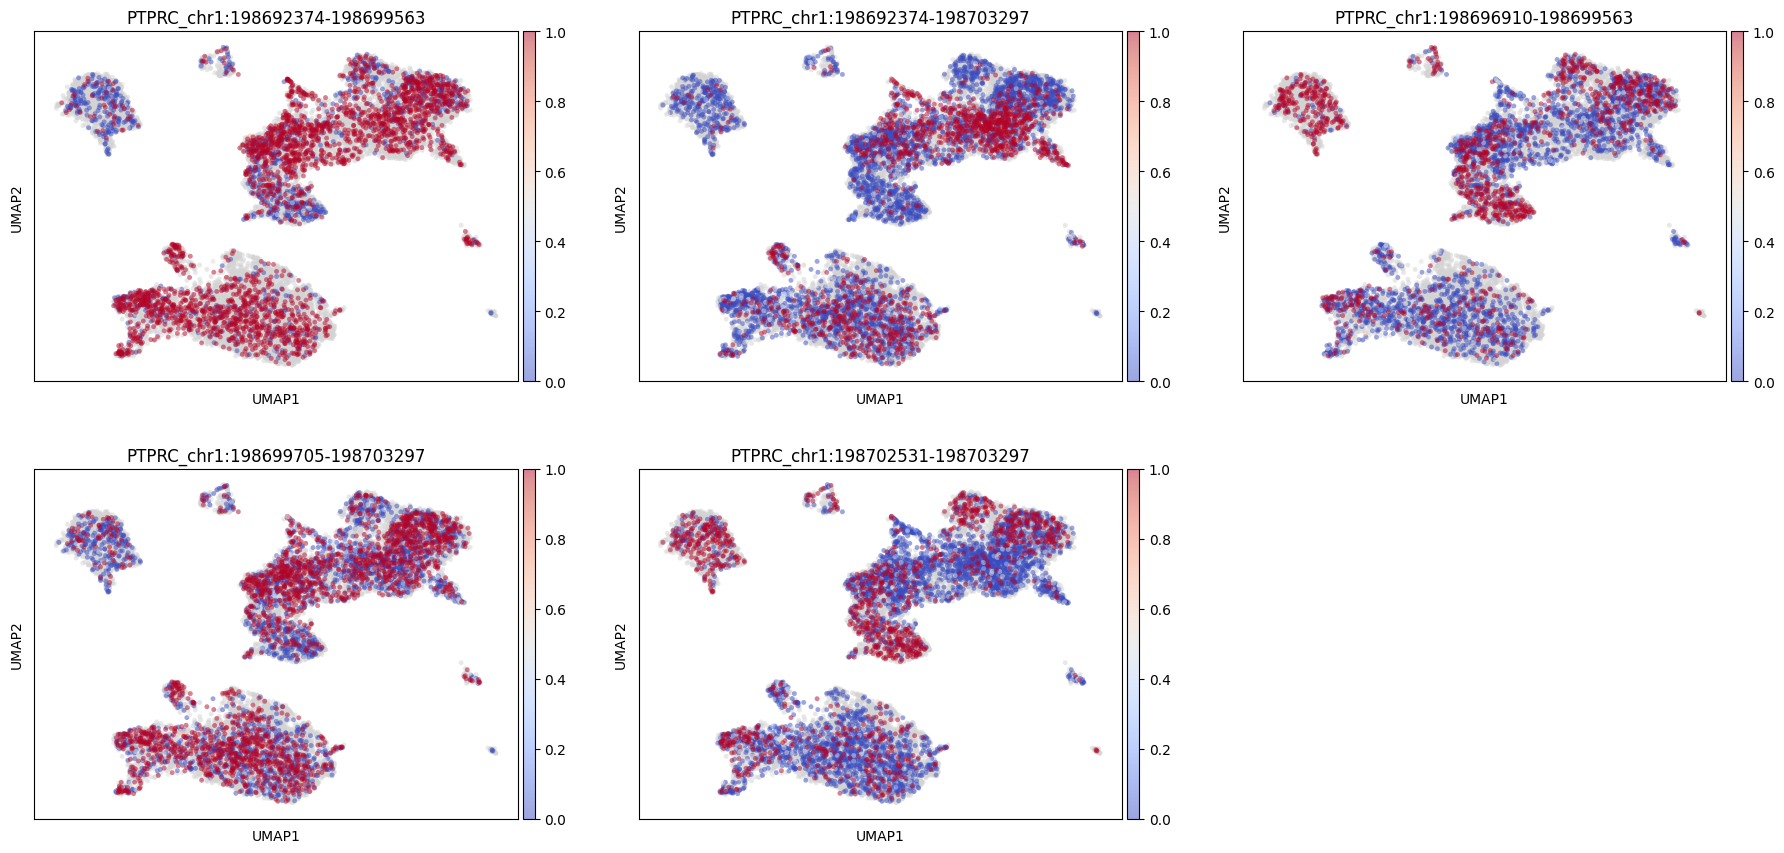

In [39]:
sc.pl.umap(
    adata_spl,
    color=[i for i in adata_spl.var_names if i.startswith('PTPRC')],
    cmap='coolwarm',
    layer="PSI_raw", 
    vmin=0, vmax=1, ncols=3, size=50, alpha=0.5,

)


In [40]:
import matplotlib as mpl

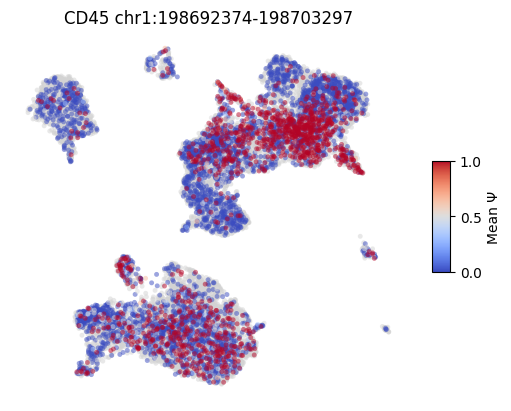

In [41]:

fig, ax = plt.subplots(1,1)

sc.pl.umap(adata_spl,
           color=['PTPRC_chr1:198692374-198703297'],
           layer="PSI_raw",
           vmax=1,
           vmin=0,
           size=50,
           ncols=1,
           cmap='coolwarm',
           frameon=False,
           ax=ax,
           colorbar_loc=None,
           alpha=0.5,
           show=False
              )

ax.set_title('CD45 chr1:198692374-198703297')

norm = mpl.colors.Normalize(vmin=0, vmax=1)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='coolwarm'), 
             ax=ax, orientation='vertical',label="Mean Ψ",
             fraction=.15,shrink=.3,aspect=6)
fig.show()

fig.savefig(output_dir+'UMAP_CD45RA_intron_1.pdf')

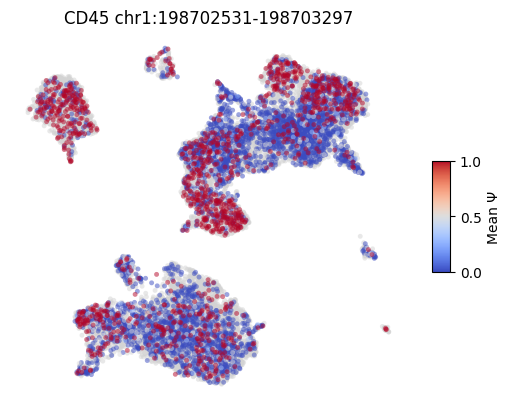

In [47]:

fig, ax = plt.subplots(1,1)

sc.pl.umap(adata_spl,
           color=['PTPRC_chr1:198702531-198703297'],
           layer="PSI_raw",
           vmax=1,
           vmin=0,
           size=50,
           ncols=1,
           cmap='coolwarm',
           frameon=False,
           ax=ax,
           colorbar_loc=None,
           alpha=0.5,
           show=False
              )

ax.set_title('CD45 chr1:198702531-198703297')

norm = mpl.colors.Normalize(vmin=0, vmax=1)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='coolwarm'), 
             ax=ax, orientation='vertical',label="Mean Ψ",
             fraction=.15,shrink=.3,aspect=6)
fig.show()

fig.savefig(output_dir+'UMAP_CD45RA_intron_1-.pdf')

### sashimi tracks

In [30]:
import os
from pybiomart import Dataset
from pygenometracks import tracks
from IPython.display import Image

ModuleNotFoundError: No module named 'pybiomart'

In [ ]:
os.makedirs('./sashimi_plots', exist_ok=True)

In [ ]:
sashimi_introns = diff_spl_introns[diff_spl_introns['gene_name'] == "PTPRC"]

In [ ]:
sashimi_introns

In [ ]:
groups_test

In [ ]:
sashimi_introns

In [ ]:
link_files=[]

for name in groups_test:
    if name in sashimi_introns.test_group.unique():
        
        link_files.append(name)
        
        sashimi_introns_ = sashimi_introns[sashimi_introns.test_group == name]
        
        intron_groups = sashimi_introns_.intron_group.unique()
        
        f = open(f"./sashimi_plots/link_{name}.txt", "w")
        
        for group in intron_groups:
                
                number_introns = sashimi_introns_[sashimi_introns_.intron_group == group].intron_group_size.values[0]
        
                for intron in range(number_introns):
                    f.write(str(sashimi_introns_[sashimi_introns_.intron_group == group].iloc[[intron]]['chromosome'].values[0])+'\t'
                        +str(sashimi_introns_[sashimi_introns_.intron_group == group].iloc[[intron]]['start'].values[0])+'\t'
                        +str(sashimi_introns_[sashimi_introns_.intron_group == group].iloc[[intron]]['start'].values[0])+'\t'
                        +str(sashimi_introns_[sashimi_introns_.intron_group == group].iloc[[intron]]['chromosome'].values[0])+'\t'
                        +str(sashimi_introns_[sashimi_introns_.intron_group == group].iloc[[intron]]['end'].values[0])+'\t'
                        +str(sashimi_introns_[sashimi_introns_.intron_group == group].iloc[[intron]]['end'].values[0])+'\t'
                        +str(sashimi_introns_[sashimi_introns_.intron_group == group].iloc[[intron]]['psi_a'].values[0])+'\n'
                       )
        f.close()

In [ ]:
for i in sashimi_introns_.intron_group.unique():
    print(i)

In [ ]:
sashimi_introns_.iloc[[1]]

In [ ]:
# sc.pl.umap(adata_spl,
#            color='ct2'
#           )

In [ ]:
# adata_spl_1 = adata_spl[adata_spl.obs.batch == '22']
# adata_spl_2 = adata_spl[adata_spl.obs.batch == '23']

# adata_spl_1.obs_names = adata_spl_1.obs_names.str[:-5]
# adata_spl_2.obs_names = adata_spl_2.obs_names.str[:-5]

In [ ]:
#adata_spl_2[adata_spl_2.obs['ct2'].isin(['T4_Mem','T4_Naive'])].obs['ct2'].to_csv('T4_subtypes.csv',header=None,sep='\t')

In [ ]:
adata_spl[adata_spl.obs['ct2'].isin(['T4_Mem','T4_Naive'])].obs['ct2']

In [ ]:
sc.pl.umap(adata_spl,
           color='ct2',
           palette='Spectral_r'
          )

In [ ]:
colors = pd.DataFrame(adata_spl.uns['ct2_colors'],
             index=adata_spl.obs['ct2'].cat.categories,
             columns=['color']
        
            )

In [ ]:
##write ini file


ini_file = """
[spacer]
height = 0.1
"""

bw_path = '/c4/home/derek/data1/derek/data_scSLR/PBMC/concat_BAMS/'

for name in link_files:

    ini_file = ini_file + f"""

[sashimi file test]
title = {name}
link_file = ./sashimi_plots/link_{name}.txt
# Path to bigwig file
bw_file = {bw_path}/{name}.bw
# Path to links file
height = 10
bw_color = {colors.loc[name]['color']}
number_of_bins = 20000
max_value = 1500
min_value = 0
nans_to_zeros = true
summary_method = mean
show_data_range = true
link_color ={colors.loc[name]['color']}
fontsize = 10
# The link in Sashimi plot is a Bezier curve.
# The height of the curve is calculated from the length of the intron.
# When the y-axis in bigwig track is different, the height of curve needs to be scaled.
# The line width for links is proportion to the numbers at the last column in links file (PSI).
# But the absolute width is calculated from the supplied numbers, which can look too thin or too wide sometimes.
# Use scale_line_width to scale the absolute line widths.
# You may need to try several values to get a satisfying result.
scale_link_height = 4
scale_line_width = 3
show_number = true
file_type = sashimiBigWig


"""

ini_file = ini_file + """
[spacer]
height = 1

[genes]
color = black  
file = /c4/home/derek/data1/HDD-2/derek/reference/refdata-gex-GRCh38-2020-A/genes/genes.gtf
height = 7
# title = gtf
# fontsize = 10
file_type = gtf
gene_rows = 10

"""
    
print(ini_file, file=open('./sashimi_plots/sashimi.ini','w'))


    


In [ ]:
from pybiomart import Dataset

dataset = Dataset(name='hsapiens_gene_ensembl',
                  host='http://www.ensembl.org')

genes = dataset.query(attributes=['external_gene_name','chromosome_name','start_position','end_position'],
              )

In [ ]:
genes[genes['Gene name'] == 'PTPRC']

In [ ]:
!pyGenomeTracks --tracks ./sashimi_plots/sashimi.ini --region 'chr1:198690000-198707476' -o ./sashimi_plots/sashimi_PTPRC.png

In [ ]:
Image(filename='./sashimi_plots/sashimi_PTPRC.png',retina=False)

In [ ]:
!conda list